# Nested Sampling
Nested sampling is used for calculating the normalization constant in Bayesian inference. The normalization constant is also called evidence.

## 1. Analytical Results of A Simple Gaussian Problem
Considering the following Bayesian problem:  
In $C$ dimension, the parameter $\theta = (\theta_0, \theta_1, ..., \theta_C)$ has uniform prior within the unit sphere
$$\pi(\theta) = \frac{(C/2)!}{\pi^{C/2}} \text{ in } \{\theta \ |\ r^2 = \sum_{i=1}^{C}{\theta_i^2} \lt 1\}.$$
The likelihood function is 
$$L(\theta) = \text{exp}(-\frac{r^2}{2\sigma^2}), \ r^2 = \sum_{i=1}^{C}{\theta_i^2}.$$
If we take $\sigma << C^{-1/2}$, almost all the likelihood is well within the prior domain. The evidence is approximately equal to
$$Z = \int{L(\theta)\cdot\pi(\theta)}d\theta \approx (\frac{C}{2})!(2\sigma^2)^{C/2}.$$
If we take $C = 10, \sigma = 0.01$, the numerical result of logZ is -37.80, and the approximation is $\frac{C}{2}!(2\sigma^2)^{C/2} = -37.80.$

The prior mass within the ball $\{\theta \text{ | } \sum_{i=1}^C{\theta_i^2} \leq r\}$ is
$$X = r^C.$$
Hence the likehood function is
$$L(X) = \text{exp}(-X^{2/C}/2\sigma^2)$$.

The evidence is also given by

$$Z = \int_0^1{L(X)}dX = \int_0^1{\text{exp}(-X^{2/C}/2\sigma^2)}dX.$$

It's difficult to visilize where the bulk of mass is using the coordinate X. Changing the  integral coordinte from X to t = logX makes the visulization easiler.

$$Z = \int_{-\infty}^0{\text{exp}(-\frac{\text{exp}(2t/C)}{2\sigma^2}+t)}dt$$


In [248]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

Plot of the integral function $L(x) = \text{exp}(-X^{2/C}/2\sigma^2)$ when X is used as the integral variable.

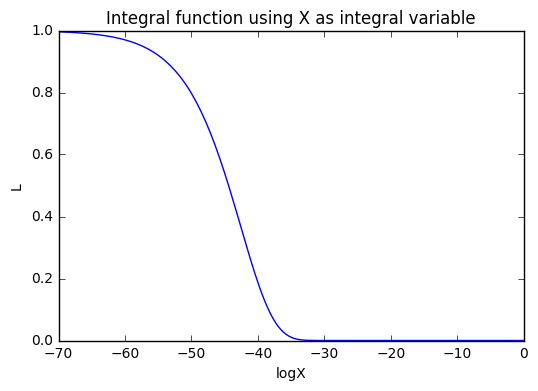

In [249]:
## parameters
C = 10
sigma = 0.01

## plot L(X) when the integral coordinate is X
def L_logx(logx, C = 10, sigma = 0.01):
    return np.exp(-np.exp(logx*2/C)/(2*sigma**2))
logX = np.linspace(-70, 0, 200)
L = []
for logx in logX:
    L.append(L_logx(logx, C, sigma))
plt.plot(logX, L)
plt.xlabel("logX")
plt.ylabel("L")
plt.title("Integral function using X as integral variable")

The plot of the integral function $\text{exp}(-\frac{\text{exp}(2t/C)}{2\sigma^2}+t)$ when $t = \text{log}X$ is used as the integral variable.

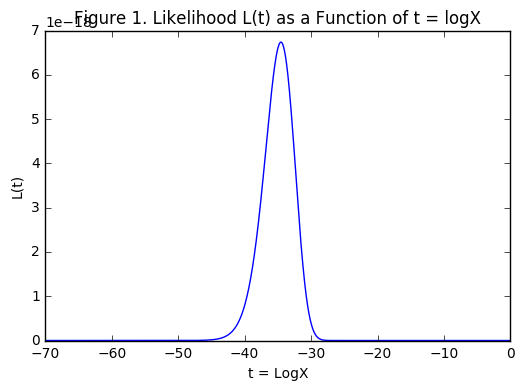

In [250]:
## define the function L(t)
def L_t(t, C = 10, sigma = 0.01):
    return np.exp(-1/(2*sigma**2)*np.exp(2*t/C) + t)

## plot the function L(t)
T = np.linspace(-70,0,1000)
Y = []
for t in T:
    Y.append(L_t(t))
plt.plot(T,Y)
plt.xlabel("t = LogX")
plt.ylabel("L(t)")
plt.title("Figure 1. Likelihood L(t) as a Function of t = logX")

It is clear from the Figure 1 that the bulk of mass contributing most to the value of evidence Z is around $t = \text{log}(X) = -34.$ Another observation is that $L(t)$ is a Gaussian shape distribution. To estimate where the peak is and how large is the variance, we can expand the log of integral function $\text{log}(L(t)) = -\frac{\text{exp}(2t/C)}{2\sigma^2}+t$ using Taylor series around its maximum point.

The derivative of $\text{log}(L(t))$ is given by

$$\frac{d\text{log}(L(t))}{dt} = 1 - \frac{1}{C\sigma^2} \text{exp}(2t/C).$$

Taking the derivative to be zero, we have the maximum point at $t_M = C\text{log}\sqrt{\sigma^2C} = -34.54.$
The second derivative at the maximum point is given by

$$\frac{d^2\text{log}(L(t))}{dt^2}|_{t=t_M} = -\frac{2}{C^2\sigma^2}\text{exp}(2t/C)|_{t=t_M} = -\frac{2}{C}.$$

Therefore the distribution can be approximated by a Gaussin distribution with a mean of -34.54 and a standard variation of $\sqrt{C/2} = 2.24.$

## 2. Nested Sampling with 1 Particle for the Simple Gaussian Problem

In [251]:
def uniform_sample_from_n_ball(r, n):
    """
    Uniformally sample from the n-dimensional ball with radius r
    """
    ## sample from unit n-sphere using Gaussian distribution
    X = np.array([np.random.normal() for i in range(n)])
    X = X / np.sqrt(np.sum(X*X))
    
    ## scale
    u = np.random.uniform()
    s = u ** (1.0/n) * r
    X = s * X
    return list(X)

In [252]:
K = 80
r = 1
r_list = []
theta_list = []
L_list = []
true_X_list = []
for i in range(K):
    theta = uniform_sample_from_n_ball(r, C)
    r = np.sqrt(np.sum(np.array(theta)**2))
    L = np.exp(-r**2/(2*sigma**2))
    X = r**C
    
    theta_list.append(theta)
    r_list.append(r)
    L_list.append(L)
    true_X_list.append(X)
    
true_logX = np.log(true_X_list)

### 2.1 Estimate Z using True X

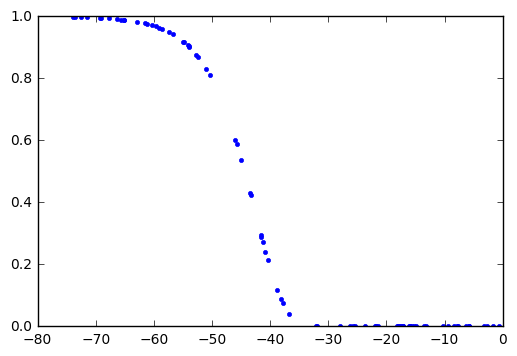

In [253]:
plt.plot(true_logX, L_list, '.')

In [254]:
def integral_L(X_list, L_list):
    """
    Integral of L with respect X given X_list and L_list
    """
    Z = 0
    Z_list = []
    for i in range(len(X_list)-1):
        Z += 0.5 * (X_list[i] - X_list[i+1]) * (L_list[i] + L_list[i+1])
        Z_list.append(Z)
    Z += (1 - X_list[0]) * L_list[0] + (X_list[-1] - 0) * L_list[-1]
    Z_list.append(Z)
    return (Z, Z_list)

Z, Z_list = integral_L(true_X_list, L_list)


In [255]:
np.log(Z)

-35.718542202001018

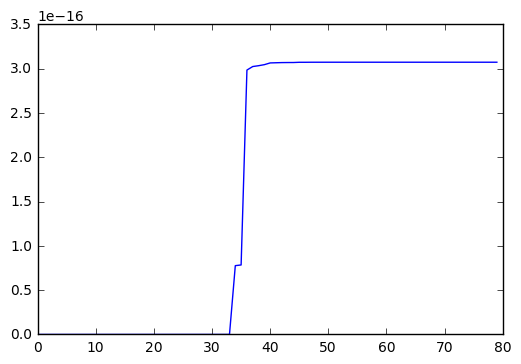

In [256]:
plt.plot(Z_list)

### 2.2 Estimate Z using Sampled X

In [257]:
sample_X_lists = []
Z_list = []
for k in range(1000):
    sample_X = 1
    tmp = []
    for i in range(len(L_list)):
        sample_X = np.random.uniform() * sample_X
        tmp.append(sample_X)
    sample_X_lists.append(tmp)
    Z,_ = integral_L(sample_X_lists[-1], L_list)
    Z_list.append(Z)

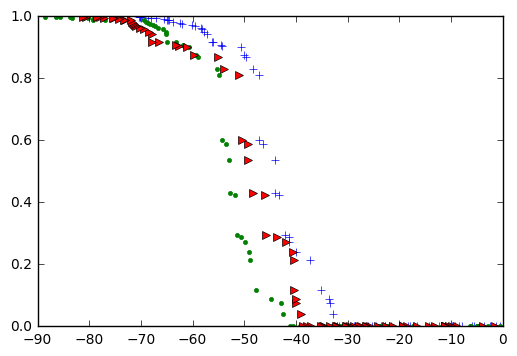

In [258]:
styles = ['+','.','>']
for k in range(3):
    plt.plot(np.log(sample_X_lists[k]), L_list, styles[k])

In [259]:
(np.mean(np.log(Z_list)), np.std(np.log(Z_list)))

(-39.942424081614938, 6.1285407665689791)

## 3. Nested Sampling with J Particle for the Simple Gaussian Problem

In [264]:
N = 10
K = 800
r = 1
thetas = [np.array(uniform_sample_from_n_ball(r, C)) for i in range(N)]
rs = [np.sqrt(np.sum(theta*theta)) for theta in thetas]
Ls = [np.exp(-r**2/(2*sigma**2)) for r in rs]


theta_list = []
L_list = []
r_list = []
true_X_list = []
for i in range(K):
    minIdx = np.argmin(Ls)
    theta = thetas.pop(minIdx)
    r = rs.pop(minIdx)
    L = Ls.pop(minIdx)
    X = r**C
    theta_list.append(theta)
    r_list.append(r)
    L_list.append(L)
    true_X_list.append(X)
    
    theta = uniform_sample_from_n_ball(r, C)
    r = np.sqrt(np.sum(np.array(theta)**2))
    L = np.exp(-r**2/(2*sigma**2))
    thetas.append(theta)
    rs.append(r)
    Ls.append(L)

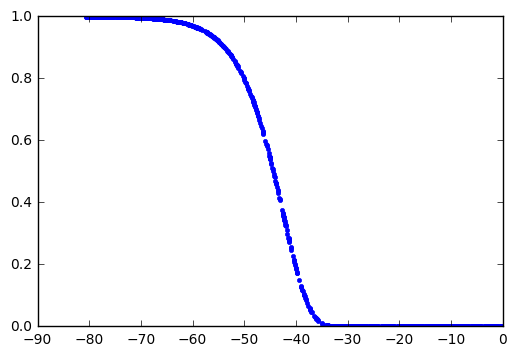

In [265]:
plt.plot(np.log(true_X_list), L_list, '.')

In [266]:
sample_X_lists = []
Z_list = []
for k in range(100):
    sample_X = 1
    tmp = []
    for i in range(len(L_list)):
        t = np.max([np.random.uniform() for m in range(N)])
        sample_X = t * sample_X
        tmp.append(sample_X)
    sample_X_lists.append(tmp)
    Z,_ = integral_L(sample_X_lists[-1], L_list)
    Z_list.append(Z)

In [267]:
(np.mean(np.log(Z_list)), np.std(np.log(Z_list)))

(-37.449858461129672, 1.6242988630216966)